In [14]:
import spectral as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sys

sys.path.append('../')
from preprocessing import *
%matplotlib inline
# matplotlib.use("wxAgg")
# %matplotlib widget

In [2]:
class_labels = ["Not labled", "Normal", "Tumor", "Hypervasculized", "Background"]
data_folder = "../datasets/helicoid/"
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01"]#, "025-02"]  # Is there anything special about these patients?

# tumor = []
# normal = []
# blood = []

# for patient in gradeIVpatients:
    
#     patient_folder = data_folder + patient
#     # img = sp.open_image(patient_folder + "/raw.hdr")
#     # white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
#     # dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
#     gt_map = sp.open_image(patient_folder + "/gtMap.hdr")
#     gt_map = gt_map.load()
    
#     # img = calibrate_img(img, white_ref, dark_ref, average_ref_pixels=True)
#     img = np.load(patient_folder + "/results/R_E_norm.npy")


#     normal_pixels = np.where(gt_map.asarray()[:,:,0] == 1) # selects pixels which labels belong to tumor class
#     for ix in range(len(normal_pixels[0])):
#         normal.append(img[normal_pixels[0][ix],normal_pixels[1][ix]])

#     tumor_pixels = np.where(gt_map.asarray()[:,:,0] == 2) # selects pixels which labels belong to tumor class
#     for ix in range(len(tumor_pixels[0])):
#         tumor.append(img[tumor_pixels[0][ix],tumor_pixels[1][ix]])

#     blood_pixels = np.where(gt_map.asarray()[:,:,0] == 3) # selects pixels which labels belong to blood class
#     for ix in range(len(blood_pixels[0])):
#         blood.append(img[blood_pixels[0][ix],blood_pixels[1][ix]])

#     print(f"{len(normal_pixels[0])} normal pixels, {len(tumor_pixels[0])} tumor pixels, {len(blood_pixels[0])} blood pixels")

# np.savez_compressed("pca_projected_preprocessed", tumor=tumor, normal=normal, blood=blood)

# # standart calibration with frageIVpatients: pca_tumor_normal_preprocessed
# # standart calibration with frageIVpatients without 025-01: pca_tumor_normal_preprocessed_new
# # projected data perpendicular to white reference and normalized: pca_projected_preprocessed

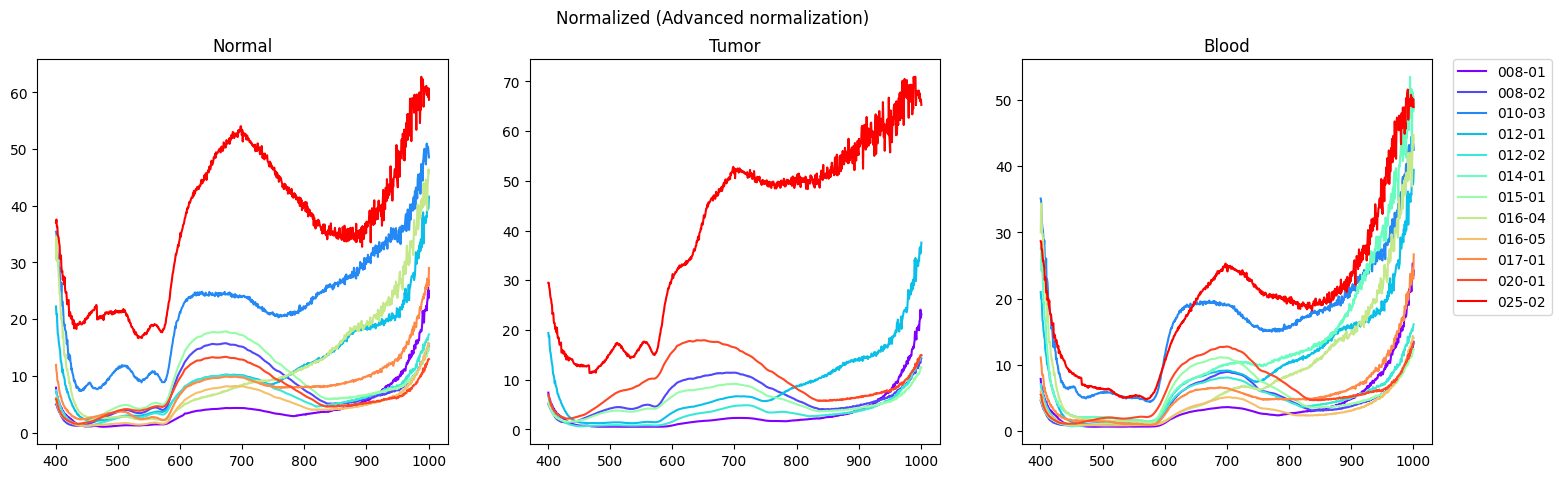

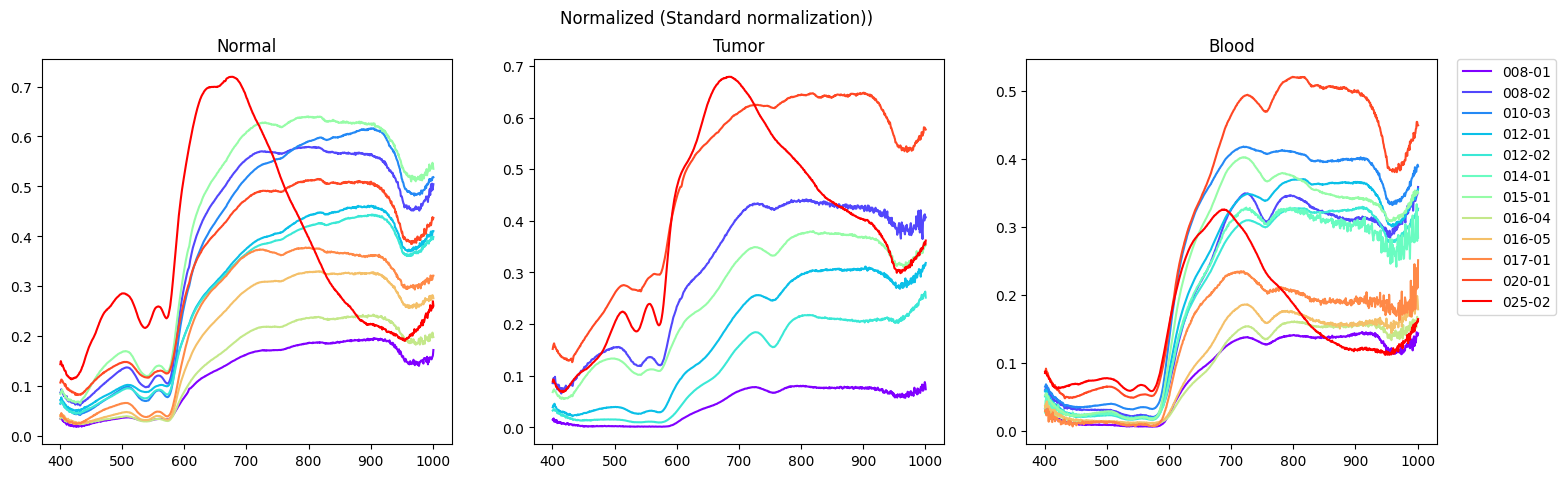

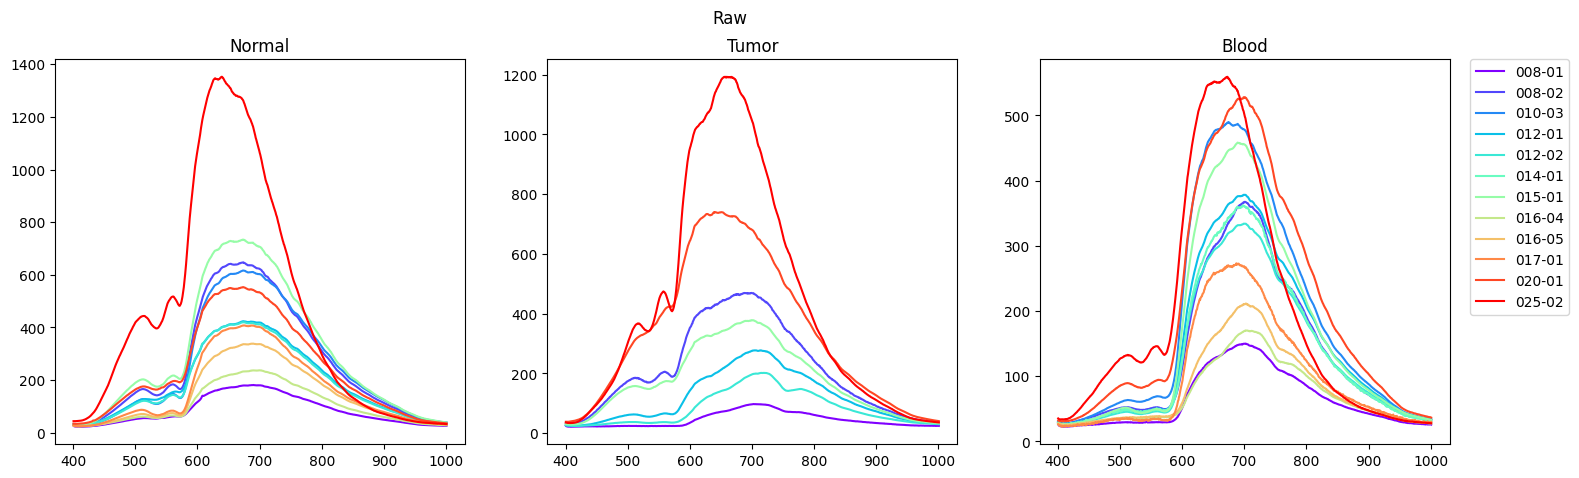

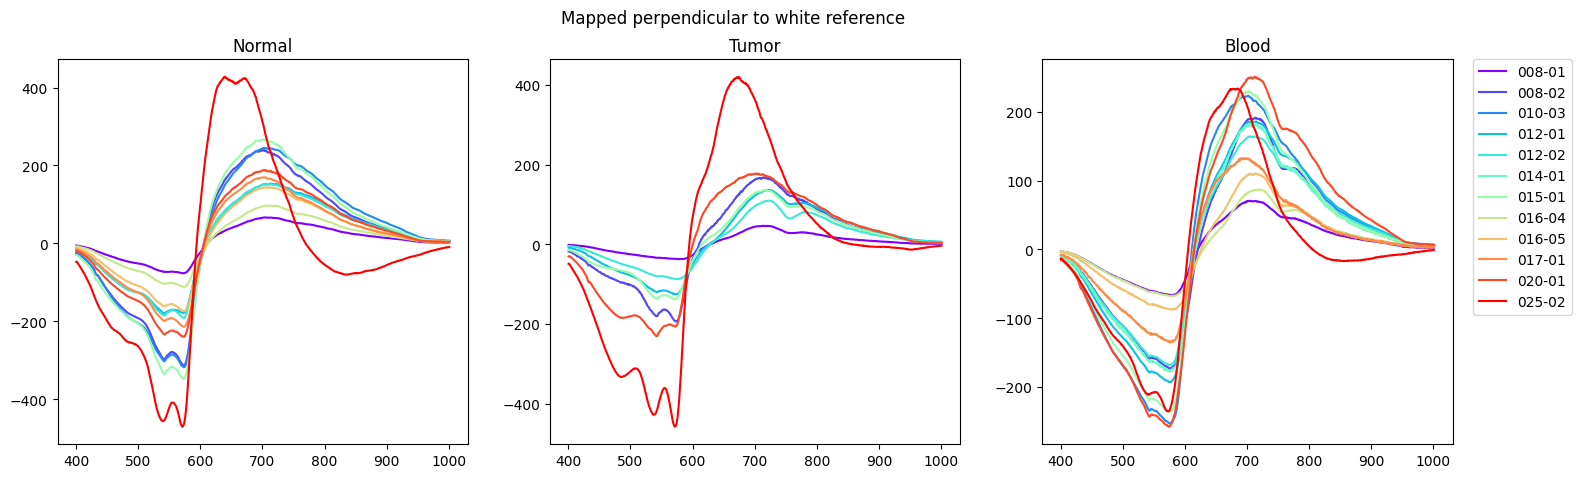

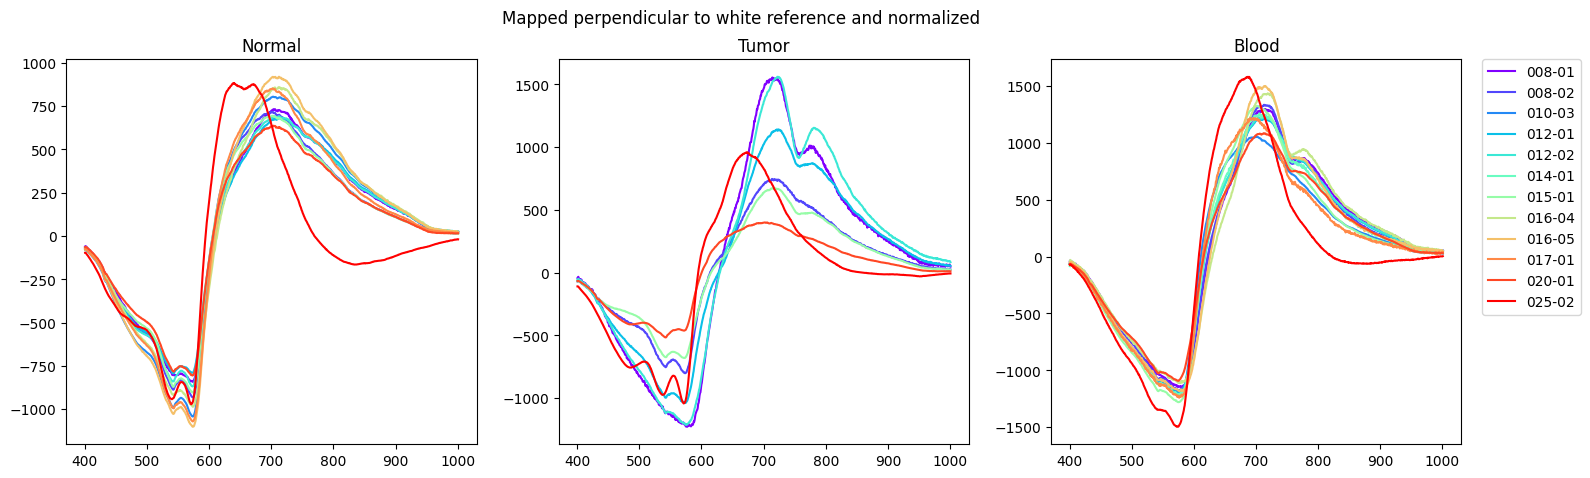

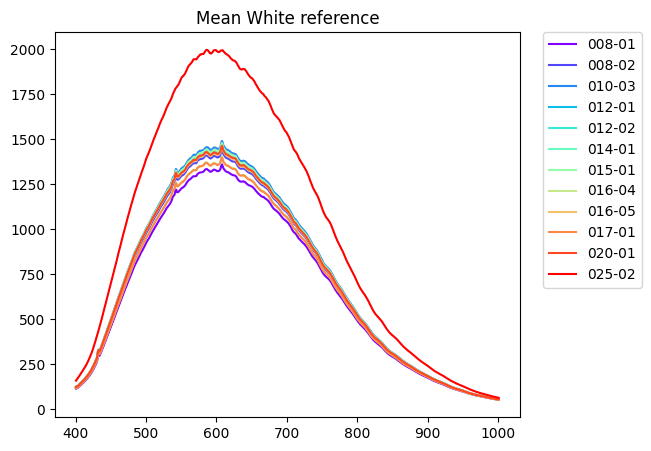

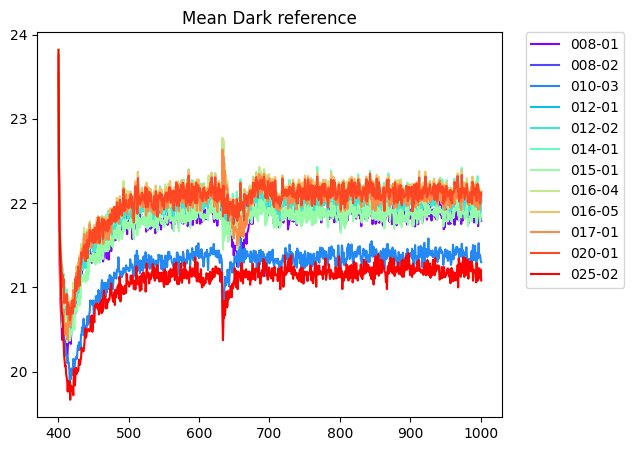

In [15]:
class_labels = ["Not labled", "Normal", "Tumor", "Hypervasculized", "Background"]
data_folder = "../datasets/helicoid/"
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01", "025-02"] 
class_ids = [1, 2, 3]

fig0, axs0 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig1, axs1 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig2, axs2 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig3, axs3 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig4, axs4 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig_white, axs_white = plt.subplots(figsize=(6,5))
fig_dark, axs_dark = plt.subplots(figsize=(6,5))
colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(gradeIVpatients)))

for n, patient in enumerate(gradeIVpatients):
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
    gt_map = sp.open_image(patient_folder + "/gtMap.hdr")
    R_E = np.load(patient_folder + "results/R_E.npy")
    R_E_norm = np.load(patient_folder + "results/R_E_norm.npy")
    
    img_processed = calibrate_img(img, white_ref, dark_ref)
    # img_processed, band_centers = band_removal(img_processed, [450.0, 900.0], img.bands.centers)
    # img_processed = smooth_spectral(img_processed)
    # img_processed = normalize_spectral_interval(img_processed)
    # img_norm = normalize_spectral_interval_mean(img_processed, class_wise=True, gt_map=gt_map)
    img_processed_advanced = calibrate_img_advanced(img, white_ref, dark_ref, average_ref_pixels=True)
    # img_processed_advanced, _ = band_removal(img_processed_advanced, [450.0, 900.0], img.bands.centers)


    # plot mean spectra (processed and raw) for each class
    for i, class_id in enumerate(class_ids):
        mask = np.where(gt_map.asarray()[:,:,0] == class_id)
        if len(mask[0]) == 0: 
            axs0[i].plot([], []) # Plot an empty line to consume a color
            axs1[i].plot([], [])  
            axs2[i].plot([], [])
            continue
        axs0[i].plot(img.bands.centers, np.mean(img_processed_advanced[mask], axis=0), color=colors[n], label=patient)
        axs1[i].plot(img.bands.centers, np.mean(img_processed[mask], axis=0), color=colors[n], label=patient)
        axs2[i].plot(img.bands.centers, np.mean(img.asarray()[mask], axis=0), color=colors[n], label=patient)
        axs3[i].plot(img.bands.centers, np.mean(R_E[mask], axis=0), color=colors[n], label=patient)
        axs4[i].plot(img.bands.centers, np.mean(R_E_norm[mask], axis=0), color=colors[n], label=patient)
        
    # plot white and dark references for patient
    axs_white.plot(img.bands.centers, np.mean(white_ref.asarray(), axis=(0,1)), color=colors[n], label=patient)
    axs_dark.plot(img.bands.centers, np.mean(dark_ref.asarray(), axis=(0,1)), color=colors[n], label=patient)

fig0.suptitle("Normalized (Advanced normalization)")
axs0[0].set_title("Normal")
axs0[1].set_title("Tumor")
axs0[2].set_title("Blood")
axs0[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

fig1.suptitle("Normalized (Standard normalization))")
axs1[0].set_title("Normal")
axs1[1].set_title("Tumor")
axs1[2].set_title("Blood")
axs1[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

fig2.suptitle("Raw")
axs2[0].set_title("Normal")
axs2[1].set_title("Tumor")
axs2[2].set_title("Blood")
axs2[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

fig3.suptitle("Mapped perpendicular to white reference")
axs3[0].set_title("Normal")
axs3[1].set_title("Tumor")
axs3[2].set_title("Blood")
axs3[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

fig4.suptitle("Mapped perpendicular to white reference and normalized")
axs4[0].set_title("Normal")
axs4[1].set_title("Tumor")
axs4[2].set_title("Blood")
axs4[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

axs_white.set_title("Mean White reference")
axs_white.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)
# fig3.savefig("mean_white_reference.svg", format="svg", bbox_inches="tight")

axs_dark.set_title("Mean Dark reference")
axs_dark.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)


c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


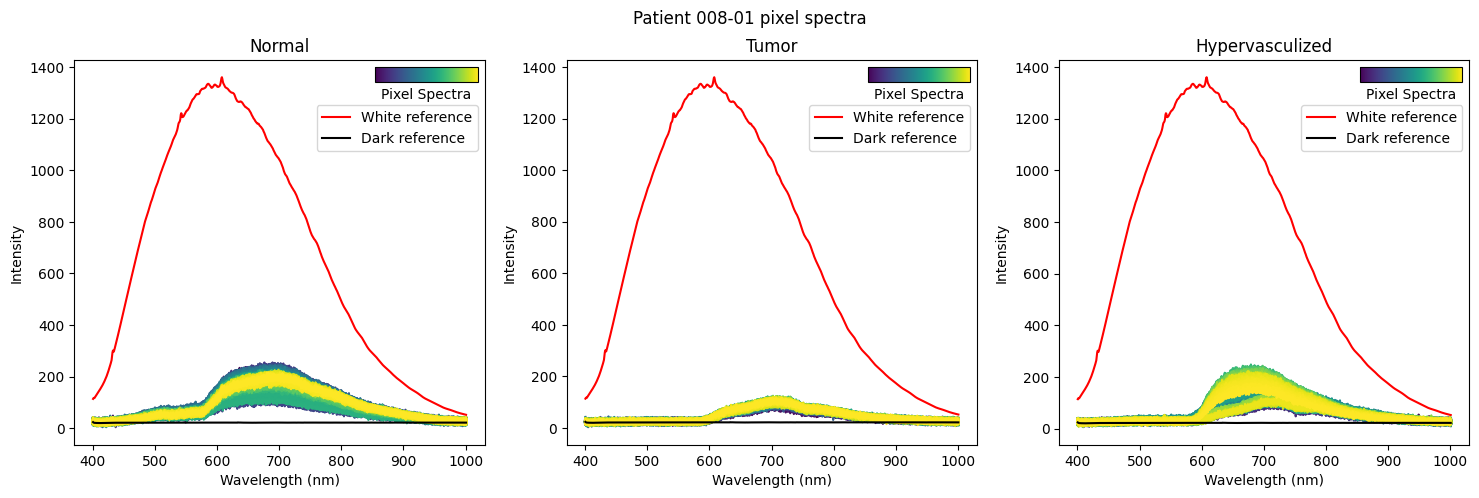

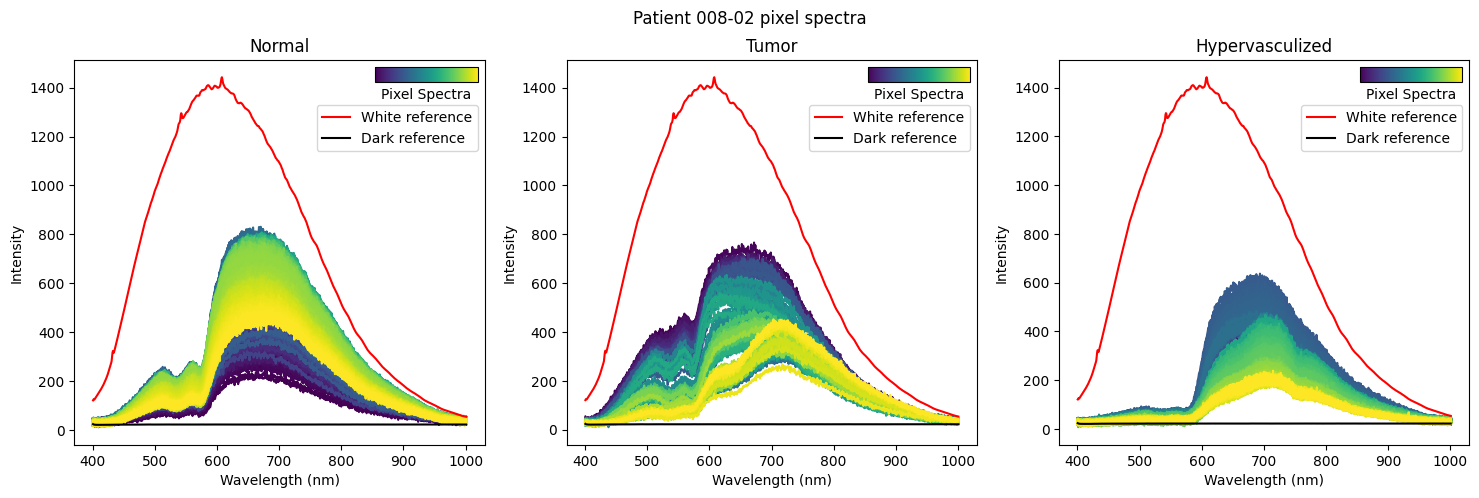

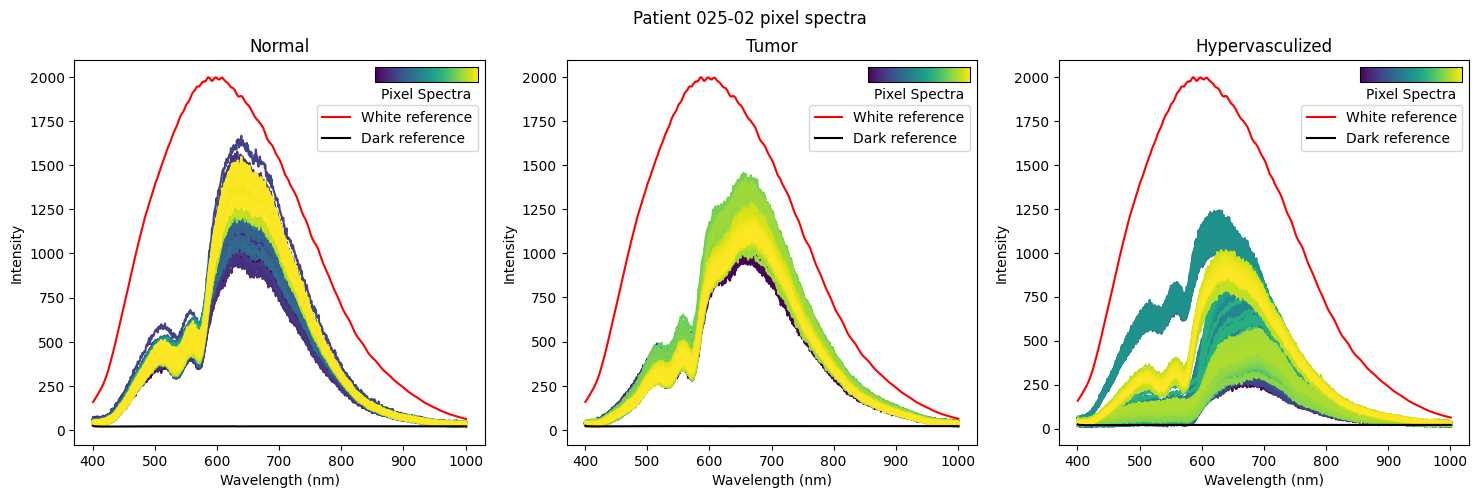

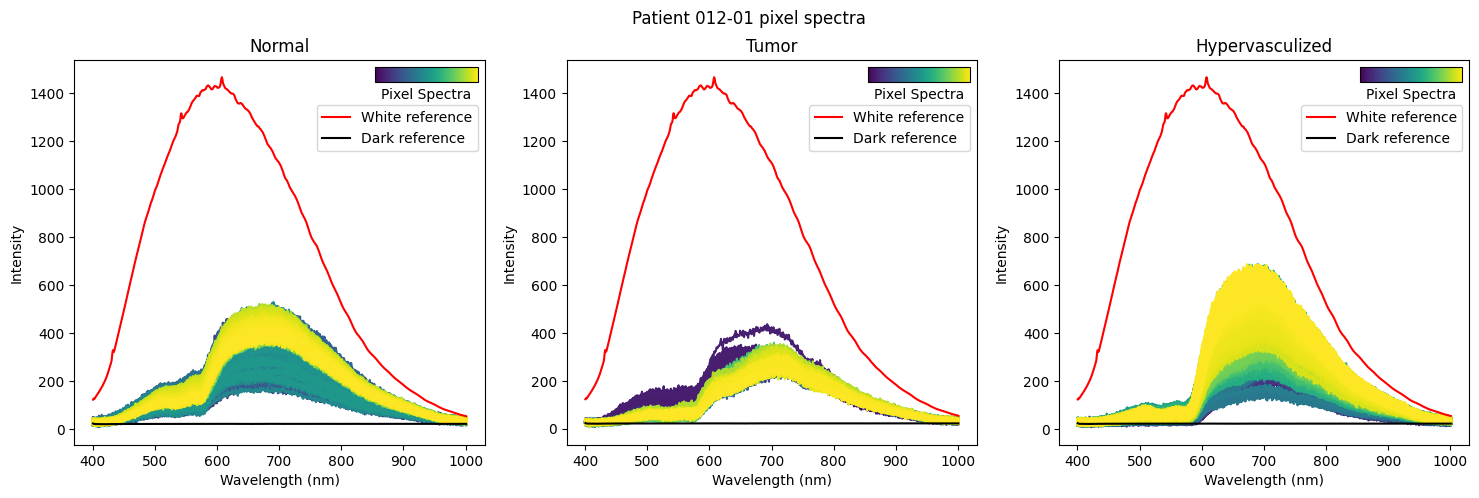

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_spectrum(spectr, wavelengths, white_ref=None, dark_ref=None, fig=None, ax=None, legend=False):
    N,T = spectr.shape

    if ax is None:
        fig, ax = plt.subplots()
    colors = matplotlib.cm.viridis(np.linspace(0, 1, T))
    for i in range(T):
        ax.plot(wavelengths, spectr[:, i], color=colors[i])
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')

    if white_ref is not None:
        ax.plot(wavelengths, np.mean(white_ref.asarray(), axis=(0,1)), color='red', label="White reference")
    if dark_ref is not None:
        ax.plot(wavelengths, np.mean(dark_ref.asarray(), axis=(0,1)), color='black', label="Dark reference")

    if legend:
        # Create a ScalarMappable for the colorbar
        sm = plt.cm.ScalarMappable(cmap=matplotlib.cm.viridis, norm=plt.Normalize(0, T - 1))
        sm.set_array(np.arange(0, T))  # Specify the array directly

        # Create a colorbar separately
        cbar_ax = inset_axes(ax, width='25%', height='4%', loc='upper right')
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cbar.ax.set_xticks([])
        cbar.set_label('Pixel Spectra')

        ax.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

    return ax


class_labels = ["Not labled", "Normal", "Tumor", "Hypervasculized", "Background"]
data_folder = "../datasets/helicoid/"
patients = ["008-01","008-02","025-02","012-01"] 
class_ids = [1, 2, 3]

for n, patient in enumerate(patients):
    fig, axs = plt.subplots(1, len(class_ids), figsize=(18,5))
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
    gt_map = sp.open_image(patient_folder + "/gtMap.hdr")

    # plot pixel spectra for each class
    for i, class_id in enumerate(class_ids):
        mask = np.where(gt_map.asarray()[:,:,0] == class_id)
        class_pixels = img.asarray()[mask]
        if len(mask[0]) == 0: 
            continue
        plot_spectrum(class_pixels.T, img.bands.centers, white_ref=white_ref, dark_ref=dark_ref, fig=fig, ax=axs[i], legend=True)
        # plot_spectrum(class_pixels.T, img.bands.centers, fig=fig, ax=axs[i], legend=True)
        fig.suptitle(f"Patient {patient} pixel spectra")
        axs[i].set_title(class_labels[class_id])

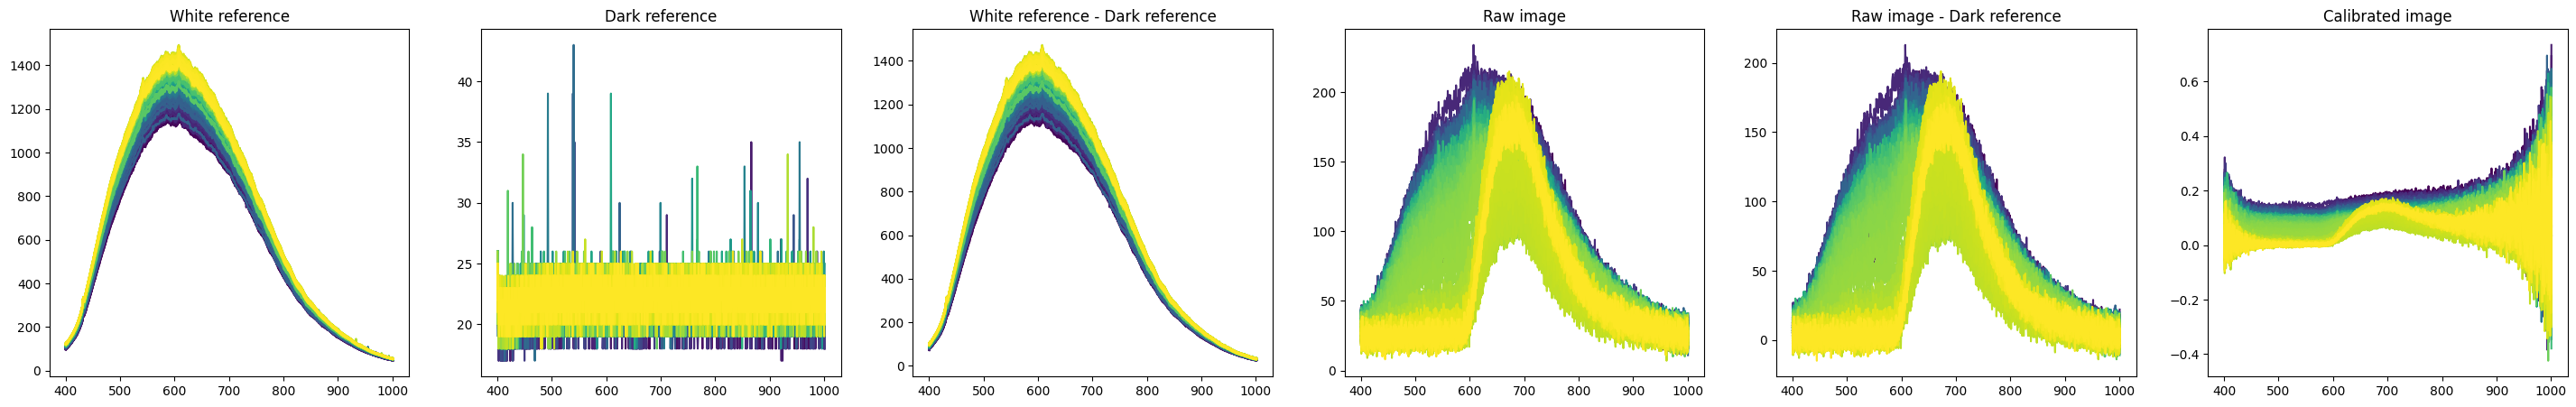

In [65]:
data_folder = "../datasets/helicoid/"
gradeIVpatients = ["008-01"]#, "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01", "025-02"] 

for n, patient in enumerate(gradeIVpatients):
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr").asarray()
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr").asarray()

    wavelengths = img.bands.centers
    img = img.asarray().astype(np.int32, casting='safe')

    fig, axs = plt.subplots(1, 6, figsize=(36,5))

    _,N,T = white_ref.shape
    colors = matplotlib.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        axs[0].plot(wavelengths, white_ref[0,i,:], color=colors[i])
        axs[1].plot(wavelengths, dark_ref[0,i,:], color=colors[i])
        axs[2].plot(wavelengths, white_ref[0,i,:] - dark_ref[0,i,:], color=colors[i])
        axs[3].plot(wavelengths, img[0,i,:], color=colors[i])
        axs[4].plot(wavelengths, np.subtract(img[0,i,:], dark_ref[0,i,:], dtype=np.float32), color=colors[i])
        axs[5].plot(wavelengths, np.divide(np.subtract(img[0,i,:], dark_ref[0,i,:], dtype=np.float32),np.subtract(white_ref[0,i,:], dark_ref[0,i,:], dtype=np.float32)), color=colors[i])


    axs[0].set_title("White reference")
    axs[1].set_title("Dark reference")
    axs[2].set_title("White reference - Dark reference")
    axs[3].set_title("Raw image")
    axs[4].set_title("Raw image - Dark reference")
    axs[5].set_title("Calibrated image")



(11054, 618) (34419, 618) (26651, 618)


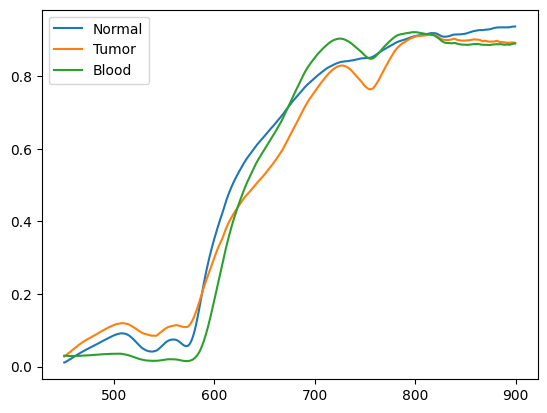

In [46]:
class_labels = ["Normal", "Tumor", "Blood"]
img = sp.open_image("helicoid/008-01/raw.hdr") # load example image to get band centers
bands = img.bands.centers

def preprocess(data):
    data, band_centers = band_removal(data, [450.0, 900.0], bands)
    data = smooth_spectral(data)
    data = normalize_spectral_interval(data)
    return data, band_centers

normal = np.load('pca_tumor_normal_preprocessed_new.npz')['normal']
normal, band_centers = preprocess(normal)

tumor = np.load('pca_tumor_normal_preprocessed_new.npz')['tumor']
tumor, band_centers = preprocess(tumor)

blood = np.load('pca_tumor_normal_preprocessed_new.npz')['blood']
blood, band_centers = preprocess(blood)

print(tumor.shape, normal.shape, blood.shape)

plt.figure()
plt.plot(band_centers, np.mean(normal, axis=0), label="Normal")
plt.plot(band_centers, np.mean(tumor, axis=0), label="Tumor")
plt.plot(band_centers, np.mean(blood, axis=0), label="Blood")
plt.legend()

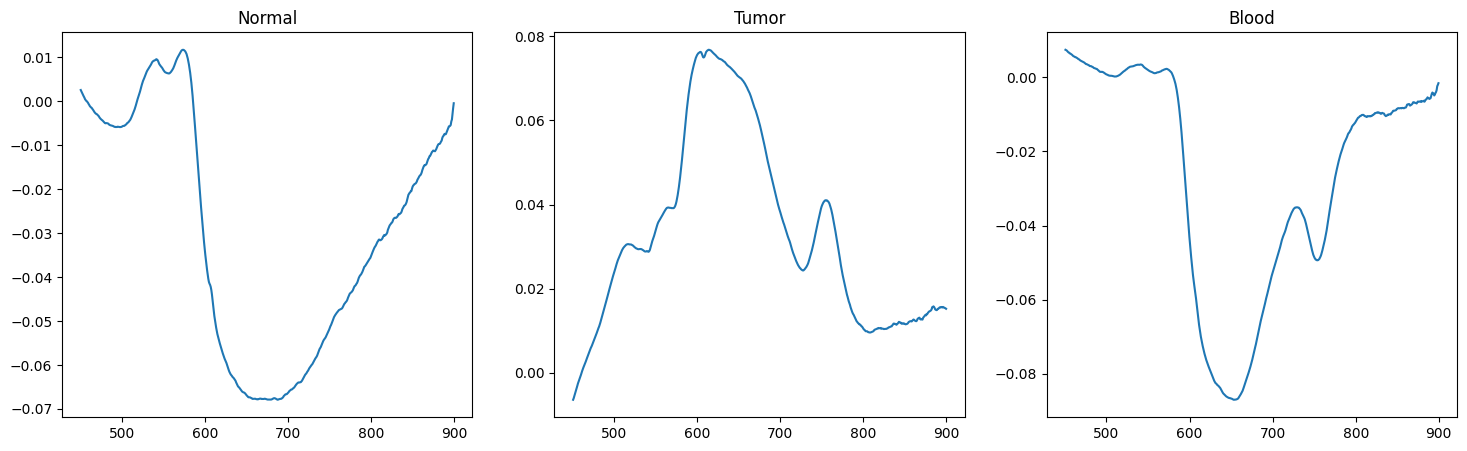

In [47]:
# Intra-class PCA

n_components = 5
pca = PCA(n_components=n_components)

plt.figure(figsize=(18,5))
# # perform PCA for each class and plot the weights
for i, data in enumerate([normal, tumor, blood]):
    pca.fit(data)
    plt.subplot(1,3,i+1)
    plt.title(class_labels[i])
    for j in range(1):
        plt.plot(band_centers, pca.components_[j])

[0.77817605 0.11743151]
[0.83059881 0.07673765]
[0.73387805 0.14004846]
[0.77598672 0.12251796]


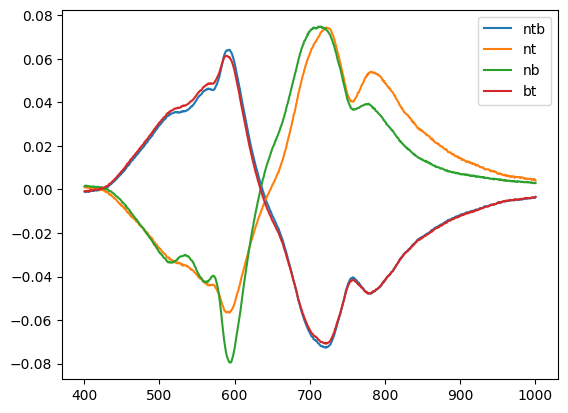

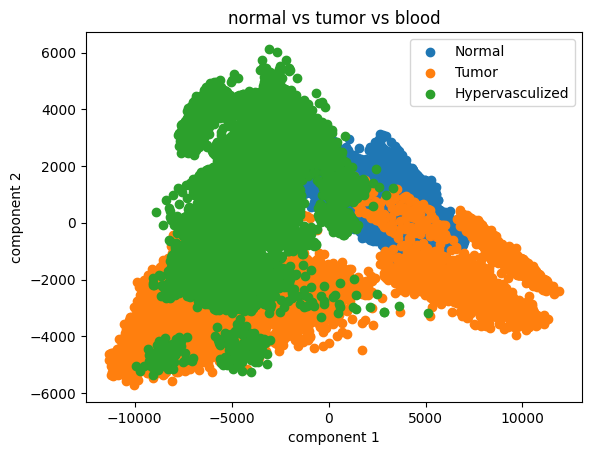

In [17]:
# Inter-class PCA
nsamples = 10000
data_file = np.load('pca_projected_preprocessed.npz')
# data_file = np.load('pca_calibrated_preprocessed_new.npz')

# load example image to get band centers
img = sp.open_image("../datasets/helicoid/008-01/raw.hdr") # load example image to get band centers
band_centers = img.bands.centers

# select 10000 random samples from each class
normal = data_file['normal']
tumor = data_file['tumor']
blood = data_file['blood']

# set seed
np.random.seed(0)
idx_N = np.random.choice(normal.shape[0], nsamples, replace=False)
N = normal[idx_N]
idx_T = np.random.choice(tumor.shape[0], nsamples, replace=False)
T = tumor[idx_T]
idx_B = np.random.choice(blood.shape[0], nsamples, replace=False)
B = blood[idx_B]

N_and_T_and_B = np.concatenate((N, T, B))
N_and_T = np.concatenate((N, T))
N_and_B = np.concatenate((N, B))
B_and_T = np.concatenate((B, T))

pca = PCA(2)
plt.figure()
pca.fit(N_and_T_and_B)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="ntb")
pca.fit(N_and_T)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="nt")
pca.fit(N_and_B)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="nb")
pca.fit(B_and_T)
print(pca.explained_variance_ratio_)
plt.plot(band_centers, pca.components_[0], label="bt")
plt.legend()

ntb = pca.fit_transform(N_and_T_and_B)

plt.figure()
Y = np.repeat([1, 2, 3], nsamples)
for i in range(1,4):
    plt.scatter(ntb[Y==i, 0], ntb[Y==i, 1], label=class_labels[i])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('normal vs tumor vs blood')
plt.legend()


# pca = PCA(3)
# ntb = pca.fit_transform(N_and_T_and_B)

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(1,4):
#     ax.scatter(ntb[Y==i,0], ntb[Y==i,1], ntb[Y==i,2], label=class_labels[i], marker='.', s=50)
# ax.set_xlabel('component 1')
# ax.set_ylabel('component 2')
# ax.set_zlabel('component 3')
# plt.legend()


c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
c:\Users\User\anaconda3\envs\thesis\lib\site-packages\spectral\io\envi.py:175: Use

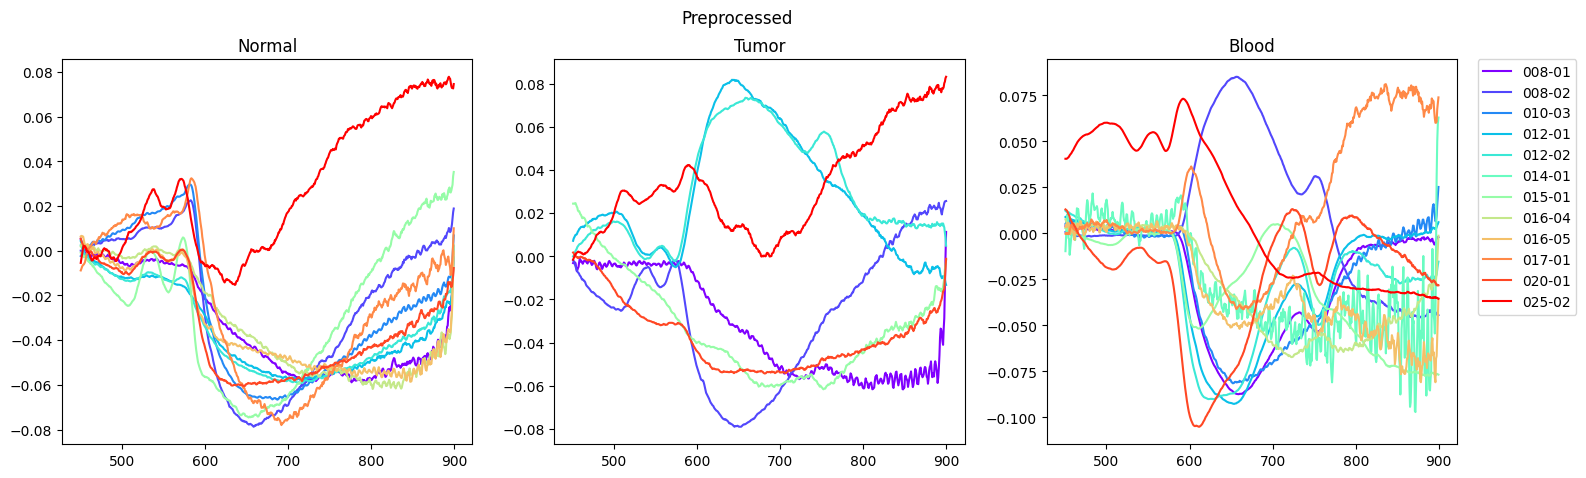

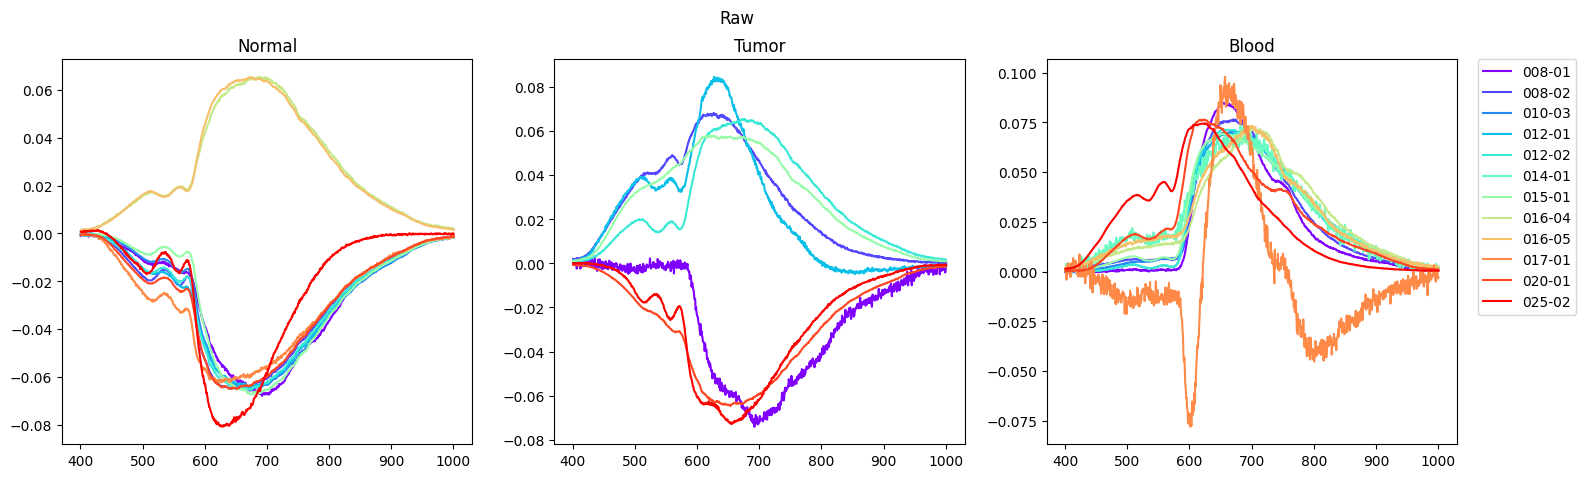

In [6]:
class_labels = ["Not labled", "Normal", "Tumor", "Hypervasculized", "Background"]
data_folder = "helicoid/"
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "014-01", "015-01", "016-04", "016-05", "017-01", "020-01", "025-02"] 
class_ids = [1, 2, 3]

fig1, axs1 = plt.subplots(1, len(class_ids), figsize=(18,5))
fig2, axs2 = plt.subplots(1, len(class_ids), figsize=(18,5))
colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(gradeIVpatients)))

for n, patient in enumerate(gradeIVpatients):
    
    patient_folder = data_folder + patient + "/"
    img = sp.open_image(patient_folder + "/raw.hdr")
    white_ref = sp.open_image(patient_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(patient_folder + "/darkReference.hdr")
    gt_map = sp.open_image(patient_folder + "/gtMap.hdr")
    
    img_processed = calibrate_img(img, white_ref, dark_ref, average_ref_pixels=True)
    img_processed, band_centers = band_removal(img_processed, [450.0, 900.0], img.bands.centers)
    img_processed = smooth_spectral(img_processed)
    img_processed = normalize_spectral_interval(img_processed)
    # img_processed = normalize_spectral_interval_mean(img_processed, class_wise=True, gt_map=gt_map)k


    pca = PCA(2)

    for i, class_id in enumerate(class_ids):
        mask = np.where(gt_map.asarray()[:,:,0] == class_id)
        if len(mask[0]) == 0:
            axs1[i].plot([], [])  # Plot an empty line to consume a color
            axs2[i].plot([], []) 
            continue

        class_pixels = img_processed[mask]
        pca.fit(img_processed[mask])
        axs1[i].plot(band_centers, pca.components_[0], color=colors[n], label=patient)
        
        class_pixels = img.asarray()[mask]
        pca.fit(img.asarray()[mask])
        axs2[i].plot(img.bands.centers, pca.components_[0], color=colors[n], label=patient)
    
fig1.suptitle("Preprocessed")
axs1[0].set_title("Normal")
axs1[1].set_title("Tumor")
axs1[2].set_title("Blood")
axs1[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)

fig2.suptitle("Raw")
axs2[0].set_title("Normal")
axs2[1].set_title("Tumor")
axs2[2].set_title("Blood")
axs2[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=10)